In [1]:
import pandas as pd
import numpy as np
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns
import time
pd.options.display.max_columns=1000
pd.options.display.max_rows=10

In [2]:
app_train = pd.read_csv('C://Users/matth/home-credit-default-risk/application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True).sample(n=10000)
app_test = pd.read_csv('C://Users/matth/home-credit-default-risk/application_test.csv').sort_values('SK_ID_CURR').reset_index(drop = True).sample(n=10000)

In [3]:
app_train.shape,app_test.shape

((10000, 122), (10000, 121))

In [4]:
app=app_train.append(app_test,ignore_index=True)
app=app.drop("SK_ID_CURR",axis=1)
len(app[app["TARGET"]==0]),len(app[app["TARGET"]==1])

(9177, 823)

In [5]:
categorical_features=app.select_dtypes(include="object").columns
unique_values=[len(app[x].unique()) for x in categorical_features]

In [6]:
label_encoding=pd.DataFrame(data=unique_values,index=categorical_features,columns=["Number of unique"]).\
sort_values(by="Number of unique",ascending=False)[:8].index

In [7]:
get_dummies=pd.DataFrame(data=unique_values,index=categorical_features,columns=["Number of unique"]).\
sort_values(by="Number of unique",ascending=False)[8:].index

In [8]:
pd.DataFrame(data=unique_values,index=categorical_features,columns=["Number of unique"]).\
sort_values(by="Number of unique",ascending=False)[:8]

,Number of unique
ORGANIZATION_TYPE,58
OCCUPATION_TYPE,19
NAME_TYPE_SUITE,8
WALLSMATERIAL_MODE,8
WEEKDAY_APPR_PROCESS_START,7
NAME_INCOME_TYPE,6
NAME_HOUSING_TYPE,6
NAME_EDUCATION_TYPE,5


In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for c in label_encoding:
    le.fit(list(app[c].values))
    app[c]=le.transform(list(app[c].values))

In [10]:
app=pd.get_dummies(app,drop_first=True)

In [11]:
correlations=app.corr()["TARGET"]

In [12]:
correlations=pd.DataFrame(correlations)
correlations["TARGET abs"]=abs(correlations["TARGET"])

In [13]:
correlations=correlations.sort_values(by="TARGET abs",ascending=False)

In [14]:
correlations[1:16]

,TARGET,TARGET abs
EXT_SOURCE_3,-0.202132,0.202132
EXT_SOURCE_1,-0.168425,0.168425
EXT_SOURCE_2,-0.166568,0.166568
DAYS_BIRTH,0.082089,0.082089
DAYS_LAST_PHONE_CHANGE,0.068442,0.068442
...,...,...
FLOORSMAX_MEDI,-0.049510,0.049510
FLOORSMAX_AVG,-0.048410,0.048410
ELEVATORS_MEDI,-0.047866,0.047866
ELEVATORS_AVG,-0.047644,0.047644


In [15]:
relevant_features=correlations.index[1:16]

In [16]:
missing_data=[app[x].isna().sum()/len(app[x]) for x in relevant_features if app[x].isna().sum()!=0]
missing_cols=[x for x in relevant_features if app[x].isna().sum()!=0]
missing_data=pd.DataFrame(data=missing_data,index=missing_cols,columns=["% of missing data"])
missing_data=missing_data.sort_values(by="% of missing data",ascending=False)
missing_data

,% of missing data
ELEVATORS_MEDI,0.52595
ELEVATORS_AVG,0.52595
EXT_SOURCE_1,0.49690
FLOORSMAX_MODE,0.48875
FLOORSMAX_MEDI,0.48875
FLOORSMAX_AVG,0.48875
EXT_SOURCE_3,0.18915
EXT_SOURCE_2,0.00075


In [17]:
ext1_corr=app.corr()["EXT_SOURCE_1"]

In [18]:
abs(pd.DataFrame(ext1_corr)).sort_values(by="EXT_SOURCE_1", ascending=False)

,EXT_SOURCE_1
EXT_SOURCE_1,1.000000
DAYS_BIRTH,0.549468
CODE_GENDER_M,0.295333
FLAG_EMP_PHONE,0.266594
DAYS_EMPLOYED,0.262362
...,...
FLAG_DOCUMENT_7,NaN
FLAG_DOCUMENT_10,NaN
FLAG_DOCUMENT_12,NaN
FLAG_DOCUMENT_17,NaN


In [19]:
missing_ext1_rows= app[app["EXT_SOURCE_1"].isna()].index

In [20]:
#This takes 100 years
for x in missing_ext1_rows:
    app.loc[x,"EXT_SOURCE_1"]=app[(app["DAYS_BIRTH"]==app.loc[x,"DAYS_BIRTH"]) & (app["CODE_GENDER_M"]==app.loc[x,"CODE_GENDER_M"])]\
    ["EXT_SOURCE_1"].median()

C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [21]:
app["EXT_SOURCE_1"].fillna(app["EXT_SOURCE_1"].median(),inplace=True)

In [22]:
ext2_corr=app.corr()["EXT_SOURCE_2"]

In [23]:
abs(pd.DataFrame(ext2_corr)).sort_values(by="EXT_SOURCE_2", ascending=False)

,EXT_SOURCE_2
EXT_SOURCE_2,1.000000
REGION_RATING_CLIENT,0.303324
REGION_RATING_CLIENT_W_CITY,0.300153
REGION_POPULATION_RELATIVE,0.202585
DAYS_LAST_PHONE_CHANGE,0.200085
...,...
FLAG_MOBIL,NaN
FLAG_DOCUMENT_2,NaN
FLAG_DOCUMENT_7,NaN
FLAG_DOCUMENT_12,NaN


In [24]:
missing_ext2_rows= app[app["EXT_SOURCE_2"].isna()].index

In [25]:
#This takes 100 years
for x in missing_ext2_rows:
    app.loc[x,"EXT_SOURCE_2"]=app[(app["REGION_RATING_CLIENT"]==app.loc[x,"REGION_RATING_CLIENT"]) & (app["REGION_RATING_CLIENT_W_CITY"]==app.loc[x,"REGION_RATING_CLIENT_W_CITY"])]\
    ["EXT_SOURCE_2"].median()

In [26]:
missing_cols=[x for x in relevant_features if app[x].isna().sum()!=0]
for x in missing_cols:
    app[x].fillna(app[x].median(),inplace=True)

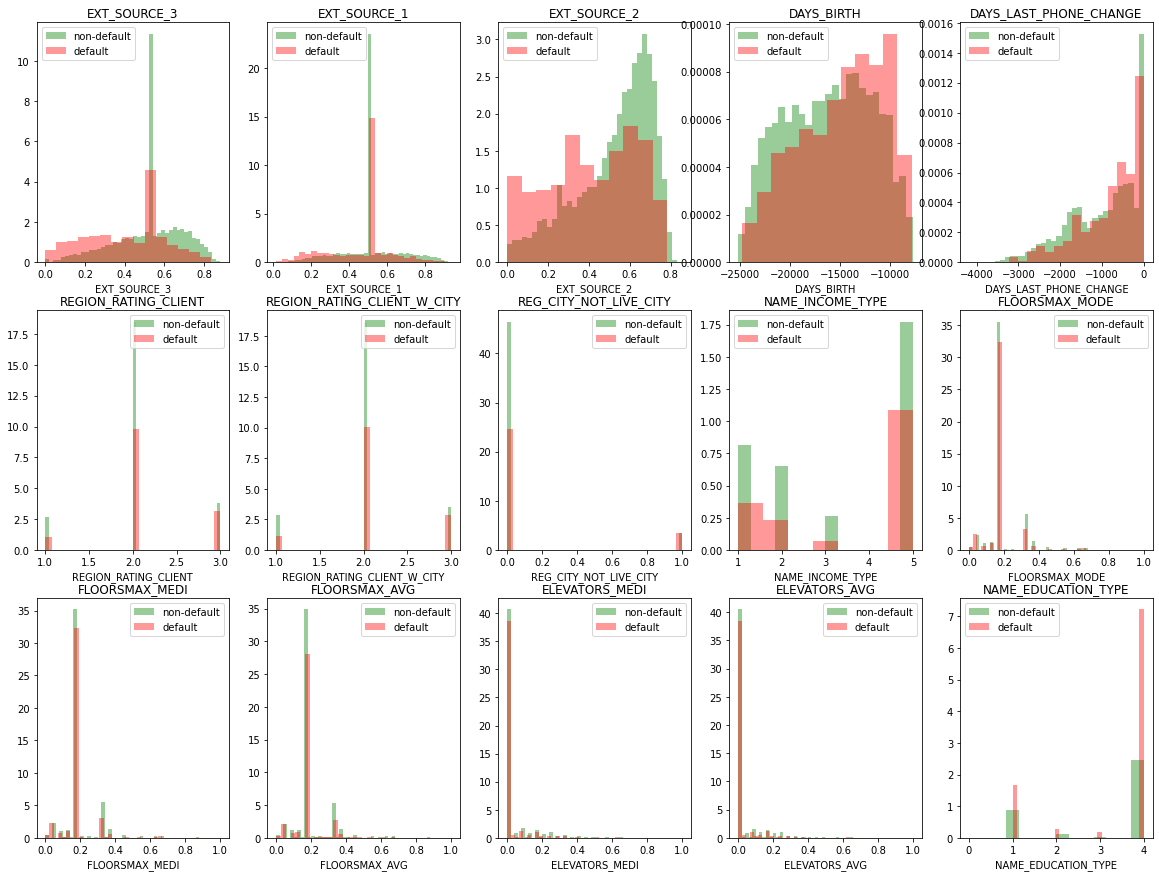

In [27]:
plt.figure(figsize=(20,15))
counter=1
for x in relevant_features:
    plt.subplot(3,5,counter)
    sns.distplot(app[app["TARGET"]==0][x],color="g",label="non-default",kde=False,norm_hist=True)
    sns.distplot(app[app["TARGET"]==1][x],color="r",label="default",kde=False,norm_hist=True)
    plt.legend()
    plt.title(x)
    counter+=1

In [28]:
ntrain=app["TARGET"].isna().sum()
y=app["TARGET"][:ntrain]
X=app[relevant_features][:ntrain]

In [29]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
poly_features=poly.fit_transform(X)
poly_features.shape,X.shape

((10000, 136), (10000, 15))

In [30]:
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2, random_state=42)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [0] are constant.
  UserWarning)
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


(<matplotlib.axes._subplots.AxesSubplot at 0x2ddbc7dfa48>,
 Text(0.5, 1.0, 'Kbest scores'))

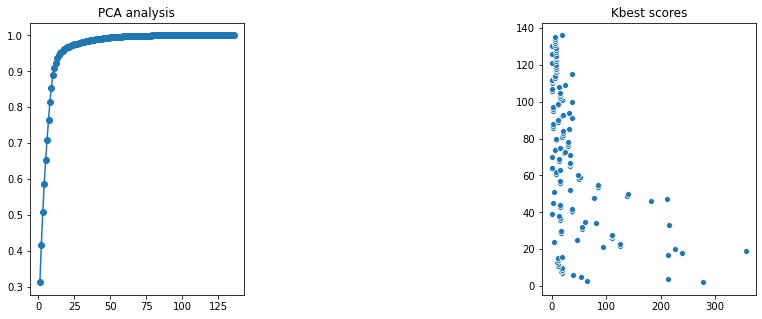

In [31]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
pca=PCA()
pca.fit(X_train)
plt.figure(figsize=(13,5))
components=range(1,len(pca.explained_variance_ratio_)+1)
plt.subplot(1,3,1)
plt.plot(components,pca.explained_variance_ratio_.cumsum(),marker='o'),plt.title("PCA analysis")
kbest=SelectKBest(k="all")
kbest.fit(X_train,y_train)
plt.subplot(1,3,3)
sns.scatterplot(kbest.scores_,components),plt.title("Kbest scores")
#I will use all relevant features for now

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

test_range=range(10,100,10)
lr=LogisticRegression(max_iter=500)
feature_scoring=pd.DataFrame(columns=["kbest score","pca score"],index=test_range)

for i in test_range:
    kbest=SelectKBest(k=i)
    pca=PCA(n_components=i)
    X_train_kbest=kbest.fit_transform(X_train,y_train)
    X_train_pca=pca.fit_transform(X_train)
    X_test_kbest=kbest.transform(X_test)
    X_test_pca=pca.transform(X_test)
    
    kbest_train=lr.fit(X_train_kbest,y_train)
    kbest_score=lr.predict_proba(X_test_kbest)[:,1]
    feature_scoring.loc[i,'kbest score']=roc_auc_score(y_test,kbest_score)
    
    pca_train=lr.fit(X_train_pca,y_train)
    pca_score=lr.predict_proba(X_test_pca)[:,1]
    feature_scoring.loc[i,'pca score']=roc_auc_score(y_test,kbest_score)
feature_scoring.sort_values(by="pca score", ascending=False,inplace=True)
feature_scoring

C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [0] are constant.
  UserWarning)
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [0] are constant.
  UserWarning)
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [0] are constant.
  UserWarning)
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid

,kbest score,pca score
80,0.744271,0.744271
90,0.743722,0.743722
70,0.742415,0.742415
30,0.7401,0.7401
40,0.739446,0.739446
20,0.739425,0.739425
60,0.737722,0.737722
50,0.73739,0.73739
10,0.733942,0.733942


In [33]:
best_features=feature_scoring.index[0]
pca=PCA(n_components=best_features)
X_train_pca=pca.fit_transform(X_train)
X_test_pca=pca.transform(X_test)
#X_train_pca=kbest.fit_transform(X_train,y_train)
#X_test_pca=kbest.transform(X_test)

In [34]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

lr=LogisticRegression()
svc=SVC(probability=True)
knn=KNeighborsClassifier()
dtr=DecisionTreeClassifier()
rfc=RandomForestClassifier()

models={"Logistic regression":lr,"Support vector classifier": svc,"K neighbours classifier":knn, \
       "Decision tree classifier": dtr, "Random forest classifier": rfc}

In [35]:
#Untuned model predictions and score
base_model_scores=pd.DataFrame(index=models.keys(),columns=[["training score","ROC AUC"]])
t0=time.time()
for key,model in models.items():
    model.fit(X_train_pca,y_train)
    train_score=cross_val_score(model,X_train_pca,y_train)
    pred=model.predict_proba(X_test_pca)[:,1]
    roc=roc_auc_score(y_test,pred)
    base_model_scores.loc[key,"training score"]=train_score.mean()
    base_model_scores.loc[key,"ROC AUC"]=roc
    print(time.time()-t0)
base_model_scores

C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

0.34707164764404297
55.9372079372406
58.46407747268677
63.266565561294556
86.10402083396912


,training score,ROC AUC
Logistic regression,0.915875,0.746604
Support vector classifier,0.9165,0.58773
K neighbours classifier,0.911375,0.625474
Decision tree classifier,0.841125,0.531594
Random forest classifier,0.9155,0.693267


In [36]:
#Untuned model average predictions
p1=lr.predict_proba(X_test_pca)[:,1]
#p2=svc.predict_proba(X_test_pca)[:,1]
#p3=knn.predict_proba(X_test_pca)[:,1]
#p4=dtr.predict_proba(X_test_pca)[:,1]
p5=rfc.predict_proba(X_test_pca)[:,1]

p_ave=(p1+p5)/2
roc_auc_score(y_test,p_ave)

0.7297945624617536

C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

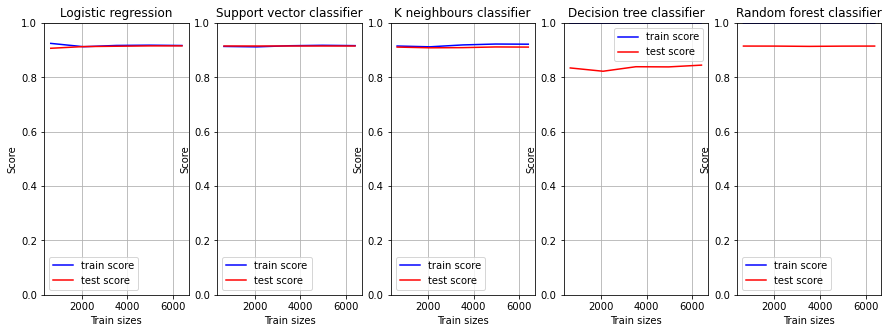

In [37]:
#from sklearn.model_selection import learning_curve
#x=1
#plt.figure(figsize=(15,5))
#for key, model in models.items():
#    train_sizes, train_scores, test_scores=learning_curve(model,X_train_pca,y_train)
#    plt.subplot(1,5,x)
#    plt.plot(train_sizes,train_scores.mean(axis=1),color="b",label="train score")
#    plt.plot(train_sizes,test_scores.mean(axis=1),color="r",label="test score")
#    plt.xlabel("Train sizes"),plt.ylabel("Score"),plt.grid(True),plt.legend(loc="best"),plt.ylim((0,1)),plt.title(key)

#    x=x+1

In [38]:
def objective(model,hyperparameters,iteration):
    cv_results=cross_val_score(model,X_train_pca,y_train).mean()
    model.fit(X_train_pca,y_train)
    pred=model.predict_proba(X_test_pca)[:,1]
    roc=roc_auc_score(y_test,pred)
    
    return (cv_results,roc,hyperparameters)


In [44]:
lr_param_grid={"penalty": ['l1','l2','elasticnet','none'],
           "C": [0.001,0.01,0.1,1,10,100],
           "dual": [True,False],
            "fit_intercept": [True,False],
            "solver": ['lbfgs', 'sag', 'saga'],
            "max_iter": [int(x) for x in np.linspace(start=100,stop=300,num=10)]}

rfc_param_grid={"n_estimators":[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
                "criterion": ['gini','entropy'],
                "max_features":["auto", "sqrt", "log2"],
                "bootstrap": [True,False]}


In [45]:
#This displaces the weird random_grid_search function
from sklearn.model_selection import RandomizedSearchCV
lr_random=RandomizedSearchCV(estimator=lr,param_distributions=lr_param_grid,n_iter=10,cv=3,verbose=2)

In [46]:
lr_random.fit(X_train_pca,y_train)
lr_random.best_params_,lr_random.best_score_,lr_random.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] solver=saga, penalty=l1, max_iter=255, fit_intercept=True, dual=False, C=0.01 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  solver=saga, penalty=l1, max_iter=255, fit_intercept=True, dual=False, C=0.01, total=   0.3s
[CV] solver=saga, penalty=l1, max_iter=255, fit_intercept=True, dual=False, C=0.01 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  solver=saga, penalty=l1, max_iter=255, fit_intercept=True, dual=False, C=0.01, total=   0.3s
[CV] solver=saga, penalty=l1, max_iter=255, fit_intercept=True, dual=False, C=0.01 
[CV]  solver=saga, penalty=l1, max_iter=255, fit_intercept=True, dual=False, C=0.01, total=   0.3s
[CV] solver=lbfgs, penalty=none, max_iter=277, fit_intercept=True, dual=False, C=100 
[CV]  solver=lbfgs, penalty=none, max_iter=277, fit_intercept=True, dual=False, C=100, total=   0.2s
[CV] solver=lbfgs, penalty=none, max_iter=277, fit_intercept=True, dual=False, C=100 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


[CV]  solver=lbfgs, penalty=none, max_iter=277, fit_intercept=True, dual=False, C=100, total=   0.2s
[CV] solver=lbfgs, penalty=none, max_iter=277, fit_intercept=True, dual=False, C=100 
[CV]  solver=lbfgs, penalty=none, max_iter=277, fit_intercept=True, dual=False, C=100, total=   0.1s
[CV] solver=sag, penalty=l2, max_iter=255, fit_intercept=True, dual=True, C=0.1 
[CV]  solver=sag, penalty=l2, max_iter=255, fit_intercept=True, dual=True, C=0.1, total=   0.0s
[CV] solver=sag, penalty=l2, max_iter=255, fit_intercept=True, dual=True, C=0.1 
[CV]  solver=sag, penalty=l2, max_iter=255, fit_intercept=True, dual=True, C=0.1, total=   0.0s
[CV] solver=sag, penalty=l2, max_iter=255, fit_intercept=True, dual=True, C=0.1 
[CV]  solver=sag, penalty=l2, max_iter=255, fit_intercept=True, dual=True, C=0.1, total=   0.0s
[CV] solver=lbfgs, penalty=none, max_iter=233, fit_intercept=False, dual=True, C=100 
[CV]  solver=lbfgs, penalty=none, max_iter=233, fit_intercept=False, dual=True, C=100, total=  

C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py", line 446, in _check_solver
    "dual=Fals

[CV]  solver=lbfgs, penalty=l2, max_iter=188, fit_intercept=False, dual=True, C=10, total=   0.0s
[CV] solver=sag, penalty=none, max_iter=211, fit_intercept=False, dual=True, C=100 
[CV]  solver=sag, penalty=none, max_iter=211, fit_intercept=False, dual=True, C=100, total=   0.0s
[CV] solver=sag, penalty=none, max_iter=211, fit_intercept=False, dual=True, C=100 
[CV]  solver=sag, penalty=none, max_iter=211, fit_intercept=False, dual=True, C=100, total=   0.0s
[CV] solver=sag, penalty=none, max_iter=211, fit_intercept=False, dual=True, C=100 
[CV]  solver=sag, penalty=none, max_iter=211, fit_intercept=False, dual=True, C=100, total=   0.0s
[CV] solver=sag, penalty=elasticnet, max_iter=188, fit_intercept=False, dual=False, C=10 
[CV]  solver=sag, penalty=elasticnet, max_iter=188, fit_intercept=False, dual=False, C=10, total=   0.0s
[CV] solver=sag, penalty=elasticnet, max_iter=188, fit_intercept=False, dual=False, C=10 
[CV]  solver=sag, penalty=elasticnet, max_iter=188, fit_intercept=Fa

C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py", line 446, in _check_solver
    "dual=False, got dual=%s" % (solver, dual))
ValueError: Solver saga supports only dual=False, got dual=True

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.3s finished


({'solver': 'saga',
  'penalty': 'l1',
  'max_iter': 255,
  'fit_intercept': True,
  'dual': False,
  'C': 0.01},
 0.9165000286442065,
 LogisticRegression(C=0.01, max_iter=255, penalty='l1', solver='saga'))

In [42]:
rf_random=RandomizedSearchCV(estimator=rfc,param_distributions=rfc_param_grid,n_iter=10,cv=3,verbose=2)
rf_random.fit(X_train_pca,y_train)
rf_random.best_params_,rf_random.best_score_,rf_random.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=1200, max_features=auto, criterion=gini, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1200, max_features=auto, criterion=gini, bootstrap=False, total=  57.4s
[CV] n_estimators=1200, max_features=auto, criterion=gini, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.3s remaining:    0.0s


[CV]  n_estimators=1200, max_features=auto, criterion=gini, bootstrap=False, total= 1.0min
[CV] n_estimators=1200, max_features=auto, criterion=gini, bootstrap=False 
[CV]  n_estimators=1200, max_features=auto, criterion=gini, bootstrap=False, total= 1.1min
[CV] n_estimators=400, max_features=log2, criterion=entropy, bootstrap=False 
[CV]  n_estimators=400, max_features=log2, criterion=entropy, bootstrap=False, total=  19.1s
[CV] n_estimators=400, max_features=log2, criterion=entropy, bootstrap=False 
[CV]  n_estimators=400, max_features=log2, criterion=entropy, bootstrap=False, total=  19.9s
[CV] n_estimators=400, max_features=log2, criterion=entropy, bootstrap=False 
[CV]  n_estimators=400, max_features=log2, criterion=entropy, bootstrap=False, total=  19.1s
[CV] n_estimators=200, max_features=sqrt, criterion=entropy, bootstrap=False 
[CV]  n_estimators=200, max_features=sqrt, criterion=entropy, bootstrap=False, total=  11.5s
[CV] n_estimators=200, max_features=sqrt, criterion=entrop

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 18.0min finished


({'n_estimators': 1000,
  'max_features': 'log2',
  'criterion': 'gini',
  'bootstrap': True},
 0.9157499348590429,
 RandomForestClassifier(max_features='log2', n_estimators=1000))

In [43]:
#Tuned model average predictions
rfc=rf_random.best_estimator_
rfc.fit(X_train_pca,y_train)
lr=lr_random.best_estimator_
lr.fit(X_train_pca,y_train)
p1=lr.predict_proba(X_test_pca)[:,1]
#p2=svc.predict_proba(X_test_pca)[:,1]
#p3=knn.predict_proba(X_test_pca)[:,1]
#p4=dtr.predict_proba(X_test_pca)[:,1]
p5=rfc.predict_proba(X_test_pca)[:,1]

p_ave=(p1+p5)/2
roc_auc_score(y_test,p_ave)

ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

In [ ]:
#Tuned model predictions
roc_auc_score(y_test,p1),roc_auc_score(y_test,p5)

In [72]:
grid_results=random_grid_search(rfc,rfc_param_grid)
grid_results

8.236416816711426
16.35598087310791
24.660570859909058
33.055015087127686
41.43331837654114
49.834627866744995
57.667078256607056
65.49379253387451
73.33470416069031
81.38348007202148


,training score,test ROC AUC,Hyperparameters
0,0.918125,0.666657,"{'n_estimators': 1400, 'criterion': 'entropy',..."
1,0.9175,0.66124,"{'n_estimators': 2000, 'criterion': 'entropy',..."
2,0.917,0.660094,"{'n_estimators': 200, 'criterion': 'entropy', ..."
3,0.9175,0.659825,"{'n_estimators': 1000, 'criterion': 'entropy',..."
4,0.917625,0.658932,"{'n_estimators': 200, 'criterion': 'entropy', ..."
5,0.917375,0.656448,"{'n_estimators': 1600, 'criterion': 'gini', 'm..."
6,0.918,0.655609,"{'n_estimators': 800, 'criterion': 'gini', 'ma..."
7,0.917125,0.654232,"{'n_estimators': 1600, 'criterion': 'gini', 'm..."
8,0.9175,0.650374,"{'n_estimators': 400, 'criterion': 'entropy', ..."
9,0.917625,0.635614,"{'n_estimators': 1200, 'criterion': 'entropy',..."


In [131]:
KNeighborsClassifier?

In [84]:
import itertools

def grid_search(model,param_grid):
    t0=time.time()
    results=pd.DataFrame(columns=["training score","test ROC AUC","Hyperparameters"])
    keys,values=zip(*param_grid.items())
    i=0
    for v in itertools.product(*values):
        hyperparameters=dict(zip(keys,v))
        eval_results=objective(model,hyperparameters,i)
        results.loc[i,:]=eval_results
        t1=time.time()-t0
        print(t1)
        t1=t0
        i+=1
        if i>5:
            break
    results.sort_values("test ROC AUC",ascending=False,inplace=True)
    results.reset_index(inplace=True,drop=True)
    return results

In [85]:
#Seems like adjusting logistic regression hyperparameters has minimal impact on the results
grid_results=grid_search(lr,lr_param_grid)
grid_results

0.0481867790222168
0.11067342758178711
0.15753722190856934
0.22110295295715332
0.28031373023986816
0.3294353485107422


,training score,test ROC AUC,Hyperparameters
0,0.91925,0.71997,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."
1,0.91925,0.71997,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."
2,0.91925,0.71997,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."
3,0.91925,0.71997,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."
4,0.91925,0.71997,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."
5,0.91925,0.71997,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."


In [43]:
grid_search(rfc,rfc_param_grid)

8.49466586112976
17.33802032470703
25.912322759628296


,training score,test ROC AUC,Hyperparameters
0,0.91725,0.659414,"{'n_estimators': 200, 'criterion': 'gini', 'ma..."
1,0.9175,0.647326,"{'n_estimators': 200, 'criterion': 'gini', 'ma..."
2,0.917625,0.640413,"{'n_estimators': 200, 'criterion': 'gini', 'ma..."


In [70]:
import random
def random_grid_search(model,param_grid):
    t0=time.time()
    results=pd.DataFrame(columns=["training score","test ROC AUC","Hyperparameters"])
    keys,values=zip(*param_grid.items())
    
    for i in range(10):
        hyperparameters={k:random.sample(v,1)[0] for k,v in param_grid.items()}
        eval_results=objective(model,hyperparameters,i)
        results.loc[i,:]=eval_results
        t1=time.time()-t0
        print(t1)
        t1=t0
    results.sort_values("test ROC AUC",ascending=False,inplace=True)
    results.reset_index(inplace=True,drop=True)
    return results

In [71]:
random_grid_search(rfc,rfc_param_grid)

8.581648111343384
17.01374578475952
25.461450576782227
33.82527017593384
42.29621601104736
50.7615327835083
59.17443585395813
67.60281252861023
75.99391770362854
84.63963389396667


,training score,test ROC AUC,Hyperparameters
0,0.918125,0.664564,"{'n_estimators': 1600, 'criterion': 'gini', 'm..."
1,0.91725,0.660007,"{'n_estimators': 1800, 'criterion': 'gini', 'm..."
2,0.917625,0.658808,"{'n_estimators': 2000, 'criterion': 'entropy',..."
3,0.917375,0.65678,"{'n_estimators': 1200, 'criterion': 'gini', 'm..."
4,0.917125,0.655923,"{'n_estimators': 2000, 'criterion': 'gini', 'm..."
5,0.917625,0.653632,"{'n_estimators': 1800, 'criterion': 'entropy',..."
6,0.917375,0.653555,"{'n_estimators': 1200, 'criterion': 'gini', 'm..."
7,0.917875,0.653046,"{'n_estimators': 1400, 'criterion': 'gini', 'm..."
8,0.916875,0.644619,"{'n_estimators': 200, 'criterion': 'entropy', ..."
9,0.91725,0.642081,"{'n_estimators': 1400, 'criterion': 'entropy',..."
